In [1]:
import pandas as pd
import ta
import numpy as np
from multiprocessing import Pool
from itertools import combinations, chain
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from utils import file_features_tr, model_transformer, buy_sell_tr, backtest, create_transformer, powerset, plot_tr, plot_operations_history, port_value_plot, plot_cash, cash_portvalue_plot, pasive_portvalue_plot, plot_transacciones

### Equipo:
- 727671 - Daniela Natalia Barajas García
- 733462 - Lucía Cruz Ramírez
- 733481 - Elías Hernández Alarcón
- 728469 - Juan Pedro Sánchez Galaz

# Transformers

Los "transformers" son un tipo de arquitectura de red neuronal que se ha vuelto muy popular en el campo del procesamiento del lenguaje natural (NLP, por sus siglas en inglés) y otras tareas relacionadas con secuencias de datos, como la traducción automática y la generación de texto. A diferencia de las redes neuronales recurrentes (RNNs) y las redes neuronales convolucionales (CNNs), que se basan en operaciones secuenciales o locales, los transformers utilizan una estructura de atención que les permite procesar las entradas completas de manera simultánea.

La arquitectura del transformer se basa en el mecanismo de atención, que permite que la red se centre en diferentes partes de la entrada en función de su relevancia para la tarea en cuestión. Esto hace que los transformers sean especialmente efectivos para tareas que requieren un procesamiento de secuencia a nivel global, como la traducción de idiomas, la generación de texto coherente y la comprensión del lenguaje natural.

Los transformers han demostrado ser altamente efectivos en una variedad de aplicaciones, y modelos preentrenados como BERT (Bidirectional Encoder Representations from Transformers) y GPT (Generative Pre-trained Transformer) han establecido nuevos récords en tareas de NLP y generación de texto. En el contexto financiero, los transformers podrían aplicarse, por ejemplo, en la predicción de series temporales financieras o en el análisis de sentimientos en datos financieros no estructurados.

Estaremos trabajando con el dataset de 5m, proporcionado desde las primeras clases que contiene los datos de los precios de la accion de Apple. A continuacion se muestra el dataset y se describen sus columnas.

In [3]:
data_1 = pd.read_csv("aapl_5m_train.csv").dropna()
data_2 = pd.read_csv("aapl_5m_test.csv").dropna()
data_1

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0
...,...,...,...,...,...,...,...,...,...
39573,19787,1672432500,0,2022-12-30 20:35:00,129.020004,129.050003,128.899993,129.039993,773964.0
39574,19788,1672432800,0,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,833767.0
39575,19789,1672433100,0,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,2136910.0
39576,19790,1672433400,0,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,2879267.0


    Fecha: Indica la fecha en que se registraron los datos de precios de las acciones de Apple. Es esencial para seguir la evolución del precio a lo largo del tiempo y detectar patrones y tendencias.

    Apertura: Es el primer precio al que se negociaron las acciones de Apple en el día. Proporciona una indicación inicial de la dirección en que el precio puede moverse durante la jornada.

    Alto: Es el precio más alto alcanzado durante el día de negociación para las acciones de Apple. Indica el máximo alcanzado y la fuerza alcista del mercado.

    Bajo: Es el precio más bajo alcanzado durante el día de negociación. Indica el mínimo y la presión de venta en el mercado.

    Cierre: Es el último precio al que se negociaron las acciones en el día. Es uno de los más importantes, reflejando el valor final al que los inversores están dispuestos a comprar o vender las acciones.

    Cierre Ajustado: Considera eventos corporativos que afecten el precio de las acciones, como divisiones de acciones o dividendos. Ofrece una medida más precisa del rendimiento del precio de las acciones.

    Volumen: Indica la cantidad total de acciones de Apple negociadas durante el día. Puede señalar la fuerza detrás de los movimientos de precios: un alto volumen sugiere mayor interés y actividad, mientras que un bajo volumen puede indicar menor participación y volatilidad.

La grafica revela la distribución de los precios de cierre de las acciones de Apple en intervalos de cinco minutos, con una muestra que abarca aproximadamente 40,000 puntos de datos. Observamos una distribución que sugiere una forma cercana a la normalidad.

La variación de los precios exhibe un rango notable, con un máximo cercano a los 180 dólares y un mínimo que oscila alrededor de los 120 dólares. Este rango amplio indica la volatilidad inherente en los precios de las acciones de Apple durante el período de tiempo considerado.

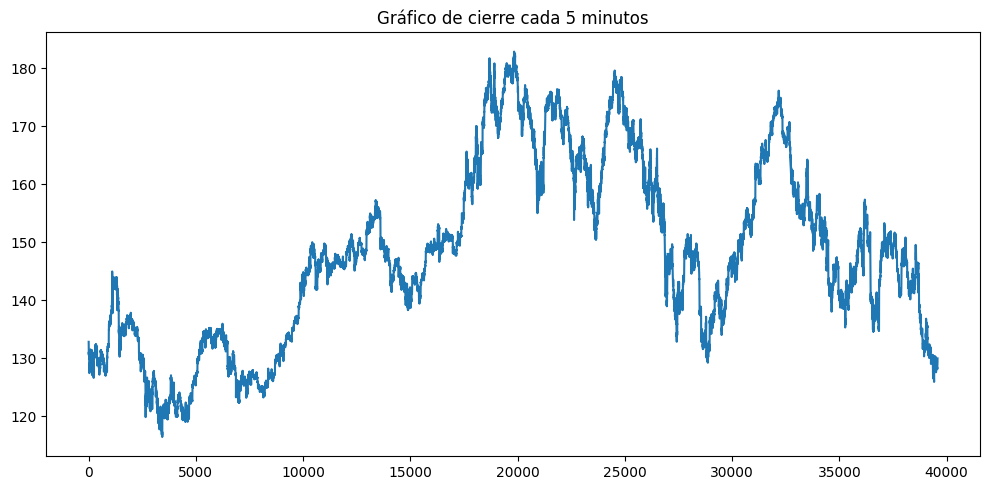

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
data_1['Close'].plot(ax=ax)
ax.set_title('Gráfico de cierre cada 5 minutos')
plt.tight_layout()
plt.show()

Las acciones de Apple (AAPL) han experimentado un crecimiento significativo en las últimas décadas. Desde su salida a bolsa en 1980, el precio de las acciones de Apple ha tenido varias tendencias alcistas y correcciones, pero en general ha mostrado una tendencia ascendente a largo plazo.

La variación del precio de las acciones de Apple a menudo está relacionada con el rendimiento de sus productos y la innovación tecnológica. El lanzamiento de nuevos productos exitosos, como el iPhone, iPad, Mac y servicios como Apple Music y Apple TV+, puede impulsar el precio de las acciones.

## Definicion de variables independientes y dependiente

### Para el análisis y entramiento de nuestro transformer, se procedio con un dataset de variables independientes, sustentadas por los siguientes puntos:
    
* Variables Independientes y Lagging:

La metodología se apoya en variables independientes, específicamente el precio de cierre (close price) de los activos financieros. Se genera un enfoque de lagging, el cual implica la creación de nuevas columnas que contienen información rezagada en el tiempo. Estas columnas con rezagos ayudan a capturar tendencias y patrones temporales en los datos históricos.
La inclusión de rezagos en el conjunto de datos es fundamental para mejorar el poder predictivo del modelo. Al considerar información pasada, el modelo puede identificar correlaciones y patrones que podrían afectar el comportamiento futuro de los precios.
* Indicadores Técnicos:
    * CMF (Chaikin Money Flow): Es un indicador que utiliza el volumen y el precio para medir la fuerza del flujo de dinero dentro o fuera de un valor durante un período determinado. Se calcula utilizando la suma de flujos de dinero durante un período y se divide por el volumen total durante ese mismo período.
    * RSI (Relative Strength Index): Es un indicador de impulso que compara las ganancias y pérdidas de un activo durante un período específico para medir la velocidad y el cambio de los movimientos de precios. Se calcula mediante una fórmula que produce un valor entre 0 y 100.
    * MACD (Moving Average Convergence Divergence): Es un indicador de tendencia que muestra la relación entre dos medias móviles de un precio de valor. Consiste en una línea MACD (diferencia entre dos medias móviles exponenciales) y una línea de señal (media móvil exponencial de la línea MACD).
    * SMA_20 (Simple Moving Average de 20 períodos): Es una media móvil simple que calcula el precio promedio de un activo durante un período específico, en este caso, 20 períodos de tiempo. Se utiliza para suavizar el movimiento de precios y ayudar a identificar la dirección de la tendencia.
    * ADX (Average Directional Index): Es un indicador que se utiliza para determinar la fuerza de una tendencia, independientemente de su dirección. Se compone de tres líneas: +DI (Índice direccional positivo), -DI (Índice direccional negativo) y ADX (Índice direccional promedio). Valores más altos del ADX indican una tendencia más fuerte.
    * CCI (Commodity Channel Index): Es un indicador de impulso que se utiliza para identificar condiciones de sobrecompra o sobreventa en un activo. Se calcula midiendo la desviación del precio de un activo con respecto a su media móvil y normalizándolo por la desviación estándar.
    * ATR (Average True Range): Es un indicador de volatilidad que mide la volatilidad promedio de un activo durante un período de tiempo específico. Se calcula tomando el mayor valor entre la diferencia entre el máximo y el mínimo de un período, la diferencia entre el máximo y el cierre anterior, y la diferencia entre el mínimo y el cierre anterior.
    

- La volatilidad es un componente crítico en el análisis de los mercados financieros. 

Se calcula como la medida de la variabilidad de los precios de un activo durante un período de tiempo específico. 
La inclusión de la volatilidad en el análisis permite al modelo tener en cuenta la incertidumbre y el riesgo asociado con el comportamiento de los precios.
Además, la volatilidad puede proporcionar información valiosa sobre la estabilidad y la dirección futura de los precios, lo que contribuye significativamente al poder predictivo del modelo.

* Volumen.
Indicador de liquidez y actividad del mercado: El volumen de las acciones refleja la actividad comercial en el mercado. Un alto volumen sugiere una mayor liquidez, lo que facilita la compra y venta de acciones sin afectar significativamente su precio. Por otro lado, un bajo volumen puede indicar menor interés o participación en el mercado, lo que podría influir en la precisión de las predicciones del modelo.

In [15]:
data_train = file_features_tr(data_1, "buy")
data_test = file_features_tr(data_2, "buy")
data_train

,Open,Close,High,Low,Volume,CMF,CMF_1,CMF_2,CMF_3,CMF_4,...,CCI_5,SO,OBV,ATR,ATR_1,ATR_2,ATR_3,ATR_4,ATR_5,Volatility
0,128.246902,128.119995,128.310104,127.910003,1314757.0,-0.265109,-0.286024,-0.232708,-0.169569,-0.202206,...,-87.828899,39.457909,-14865301.0,0.585310,0.586831,0.588027,0.589157,0.590012,0.590771,0.400101
1,128.125000,127.955001,128.210006,127.889999,982464.0,-0.249207,-0.277007,-0.296680,-0.244651,-0.182621,...,-85.171968,35.885921,-15847765.0,0.566359,0.569043,0.571276,0.573324,0.575012,0.576521,0.320007
2,127.950103,127.980003,128.020004,127.720001,1238030.0,-0.227942,-0.204535,-0.232924,-0.253612,-0.205514,...,-84.964478,38.485957,-14609735.0,0.547334,0.551107,0.554321,0.557247,0.559734,0.561967,0.300003
3,127.985000,127.710098,127.985000,127.650001,910041.0,-0.233229,-0.241996,-0.218657,-0.245612,-0.265170,...,-85.736267,32.537646,-15519776.0,0.532167,0.536699,0.540614,0.544173,0.547248,0.550021,0.334999
4,127.709999,128.229995,128.289993,127.630096,1161917.0,-0.172178,-0.187751,-0.197880,-0.177543,-0.205015,...,-57.750650,52.035077,-14357859.0,0.541291,0.544913,0.548069,0.550980,0.553507,0.555804,0.659897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39083,128.975006,128.800598,129.029998,128.789993,424949.0,0.231867,0.263483,0.241172,0.151379,0.073980,...,51.294972,67.884528,853933344.0,0.269877,0.273149,0.276042,0.278600,0.280864,0.282874,0.240005
39084,128.804992,128.830001,128.929992,128.755004,339727.0,0.177607,0.216549,0.247919,0.227665,0.141927,...,42.750207,64.285561,854273071.0,0.263100,0.266605,0.269726,0.272505,0.274982,0.277196,0.174988
39085,128.830001,128.860000,128.979995,128.809997,304726.0,0.106393,0.154596,0.194326,0.226008,0.208108,...,51.814360,64.515682,854577797.0,0.256449,0.260165,0.263493,0.266475,0.269150,0.271554,0.169998
39086,128.870498,128.755004,128.949996,128.733200,380422.0,0.056106,0.059728,0.110280,0.152323,0.185202,...,25.438000,47.580706,854197375.0,0.253617,0.257273,0.260575,0.263553,0.266241,0.268672,0.216796


Como podemos observar, en el dataset se encuentran 50 variables, sin embargo estas, al pasarlas por los lags para obtener el dataset de Xtrain, se convertiran en 150 variables. Mas adelante en las conclusiones explicamos la comparacion, pero basicamente hicimos ambas simulaciones, una con todas las variables, en donde el accuracy promedio era de 33, y una solo con 15 variables, que al final terminarian siendo 75, en donde en esta simulacion nos daba un accuracy promedio de 70%.

### Variable de respuesta

En nuestro enfoque de modelado, la variable de respuesta se basa en la comparación del precio del activo en el día actual con el precio proyectado del activo cinco días en el futuro. Si el precio proyectado es mayor que el precio actual, se recomienda una acción de venta. Por el contrario, si el precio proyectado es menor que el precio actual, se sugiere una acción de compra. En caso de que los precios sean iguales, no se recomienda ninguna acción. Sin embargo, cabe destacar que esta información no se incluyó en el reporte final, ya que simplemente implicaría la introducción de otro conjunto de datos sin una contribución sustancial al análisis principal.

## Entrenamiento del transformer para crear senales de compra venta

In [6]:
data = model_transformer(data_train, data_test)
buy_signals, sell_signals = buy_sell_tr(data)

Model: "transformers_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 75, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 75, 1)             │           7,169 │ input_layer[0][0],         │
│ (MultiHeadAttention)          │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 75, 1)             │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 75, 1)             │               2 │ dropout_1[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 75, 1)             │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 75, 4)             │               8 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 75, 4)             │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 75, 1)             │               5 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 75, 1)             │               2 │ conv1d_1[0][0]             │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 75, 1)             │               0 │ layer_normalization_1[0][… │
│                               │                           │                 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 75, 1)             │           7,169 │ add_1[0][0], add_1[0][0]   │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 75, 1)             │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 75, 1)             │               2 │ dropout_4[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 75, 1)             │               

 Total params: 45,770 (178.79 KB)

 Trainable params: 45,770 (178.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 459s 723ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.6665
Epoch 2/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 440s 720ms/step - loss: 0.5911 - sparse_categorical_accuracy: 0.6881
Epoch 3/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 442s 724ms/step - loss: 0.5921 - sparse_categorical_accuracy: 0.6845
Epoch 4/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 444s 727ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.6862
Epoch 5/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 485s 795ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.6886
Epoch 6/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 425s 695ms/step - loss: 0.5925 - sparse_categorical_accuracy: 0.6858
Epoch 7/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 420s 687ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.6843
Epoch 8/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 420s 687ms/step - loss: 0.5952 - sparse_categorical_accuracy: 0.6845
Epoch 9/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 430s 704ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.6855
Epoch 10/20
611/611

Como se puede observar, reducimos la dimensionalidad de las epocs, esto debido a 2 factores principales: 
* El principal factor fue el tiempo y el rendimiento de nuestras maquinas, por motivos que se acercaba la fecha y con miles de otros proyectos, decidimos reducir las epocs para trabajar mas rapidamente. 
* El segundo factor no menos importante es que reducir la cantidad de épocas en un modelo de Transformers puede ser beneficioso por varias razones fundamentales. Primero, al observar que el rendimiento del modelo se estabiliza después de cierto punto, con cambios mínimos en el desempeño a medida que aumentan las épocas, se evidencia que el modelo alcanza su capacidad de aprendizaje en un período relativamente corto. Esto sugiere que continuar el entrenamiento más allá de ese punto es redundante y consume recursos computacionales innecesarios. Segundo, al realizar varios escenarios y experimentos, se pudo confirmar que el rendimiento del modelo en términos de precisión no mejora significativamente con un aumento en las épocas. Esto implica que el modelo está capturando la estructura subyacente de los datos de entrenamiento de manera efectiva en un período de tiempo más corto. Además, al llevar a cabo el backtest y observar que el rendimiento del modelo es prácticamente igual independientemente de si se utilizan 5, 20 o incluso 100 épocas, se refuerza la idea de que un número menor de épocas es suficiente para obtener resultados comparables. Esto no solo ahorra tiempo de entrenamiento, sino que también simplifica el proceso de ajuste del modelo al requerir menos iteraciones. En resumen, reducir la cantidad de épocas en un modelo de Transformers a 20, en lugar de las 100 inicialmente consideradas, resulta en un uso más eficiente de los recursos computacionales sin comprometer significativamente el rendimiento del modelo en términos de precisión. Esta optimización permite obtener resultados similares en menos tiempo, lo que es fundamental en aplicaciones donde la eficiencia computacional es crucial.

In [24]:
buy_signals

,buy_signals
0,1
1,1
2,1
3,1
4,1
...,...
39077,1
39078,1
39079,1
39080,1


Todo el proceso anterior se explica con lo siguiente:
* Datos de entrada:
    * Los datos de entrada consisten en una serie temporal de precios históricos del activo que se está negociando, así como posiblemente otros datos relevantes, como el volumen de operaciones, los indicadores técnicos (por ejemplo, RSI, MACD, etc.) y noticias financieras relacionadas. Estos datos se dividen en secuencias de entrada, donde cada secuencia corresponde a un período de tiempo específico, por ejemplo, un día de operaciones.
* Codificación de la entrada:
    * Cada secuencia de entrada se codifica utilizando una combinación de capas de incrustación (embedding) y transformadores. Las capas de incrustación asignan cada elemento de la secuencia (por ejemplo, el precio de cierre, el volumen de operaciones, etc.) a un espacio vectorial de baja dimensión. Los transformadores luego procesan estas secuencias de vectores utilizando mecanismos de autoatención para capturar las relaciones temporales y de dependencia entre los diferentes elementos de la secuencia.
* Modelado de la secuencia:
    * El modelo de transformer aprende a representar la secuencia temporal de datos de entrada de manera efectiva, capturando patrones complejos y relaciones entre los diferentes elementos. Durante el entrenamiento, el modelo se ajusta para predecir la dirección futura del precio del activo (por ejemplo, si subirá o bajará) en función de los datos históricos y cualquier otra información relevante.
* Generación de señales de compra y venta:
    * Una vez que el modelo ha sido entrenado, se puede utilizar para generar señales de compra y venta. Por ejemplo, si el modelo predice que el precio del activo aumentará en los próximos cinco días, podría generar una señal de compra. Del mismo modo, si el modelo predice una disminución en el precio del activo, podría generar una señal de venta. Estas señales se pueden generar en función de ciertos umbrales de confianza o probabilidad establecidos durante el entrenamiento.
* Evaluación y ajuste:
    * Las señales generadas se evalúan retrospectivamente en un conjunto de datos de prueba para determinar su efectividad.

In [25]:
buy_signals.value_counts()

buy_signals
1              19942
0              19140
Name: count, dtype: int64

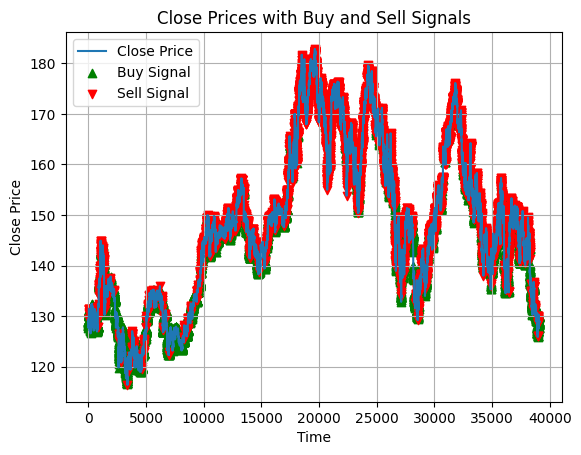

In [26]:
plot_tr(buy_signals, sell_signals, data_train)

Como podemos ver, con nuestro modelo, la estrategia optima nos dio que vendimos 19140 veces y compramos 19942 veces. A su ves en la grafica podemos ver como nuestra estrategia va actuando atraves del tiempo.

## Backtesting

El backtesting implica simular estrategias de trading utilizando datos históricos para evaluar el rendimiento de cada modelo y sus parámetros optimizados. Durante este proceso, se aplican las estrategias definidas previamente utilizando conjuntos de datos históricos para determinar su efectividad en términos de rentabilidad financiera.

El objetivo principal del backtesting es identificar la estrategia de trading que genere el mayor profit o beneficio. Este profit se calcula a partir de las ganancias y pérdidas generadas por las operaciones realizadas según las señales de compra y venta generadas por cada modelo y sus respectivos parámetros.

Al finalizar el proceso de optimización y backtesting, el código proporciona como resultado el mejor modelo, junto con los parámetros óptimos identificados durante el backtesting. Estos resultados representan la estrategia de trading más efectiva y rentable, basada en el análisis histórico de datos y la evaluación de su desempeño financiero.

Se presenta la funcion de backtesting que devuelve los parametros, ya con la funcion del backtesting y los parametros optimizados obtenidos por el proceso.

In [27]:
portfolio_value_df, capital_value_df, transactions_df = backtest(data_2, buy_signals, sell_signals, 0.6809, 1.0994972027471122, 45)

### Evolucion del portafolio atraves del tiempo

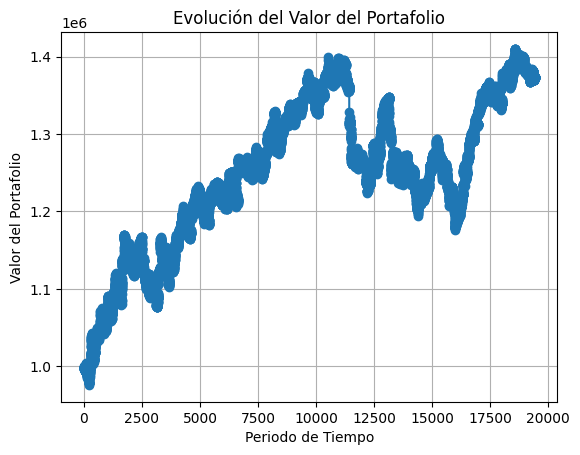

In [28]:
port_value_plot(portfolio_value_df)

Como podemos observar nuestro rendimiento generado por la estrategia del modelo creado por el transformer es bastante buena, teniendo mas de 300,000 de ganancia. 

In [33]:
portfolio_value_df[-1]

1373145.613695439

## Comparacion / Resultados

A continuacion se presenta la evolucion del dinero y del portafolio atraves de nuestra estrategia de trading, y como se esta se compara con una estrategia pasiva.

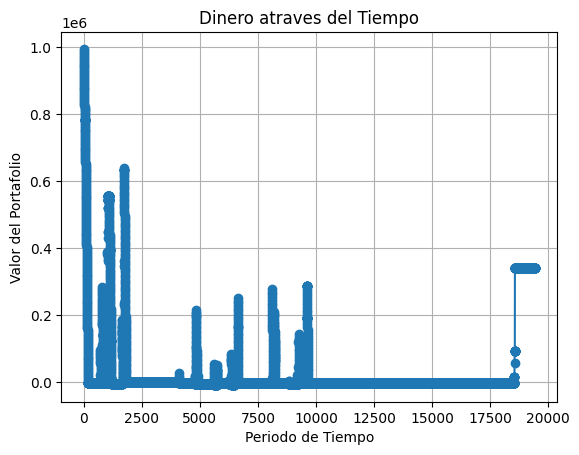

In [29]:
plot_cash(capital_value_df)

Grafica del dinero atraves del tiempo

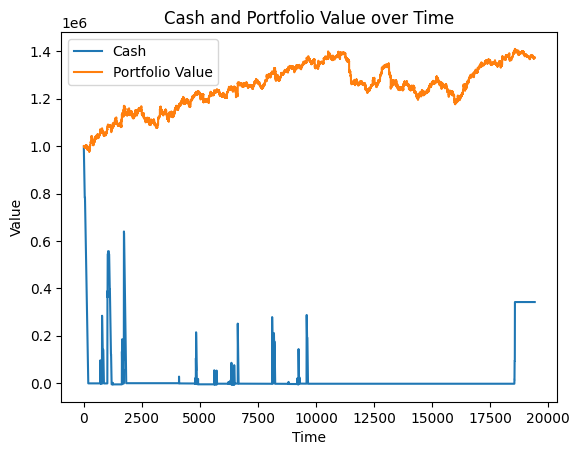

In [30]:
cash_portvalue_plot(capital_value_df, portfolio_value_df)

Como podemos ver, al menos a nivel de comparar el dinero que teniamos con nuestro portafolio, si tenemos un mayor rendimiento, esto es algo logico ya que al principio a fuerza tenemos que comprar para tener rendimientos.

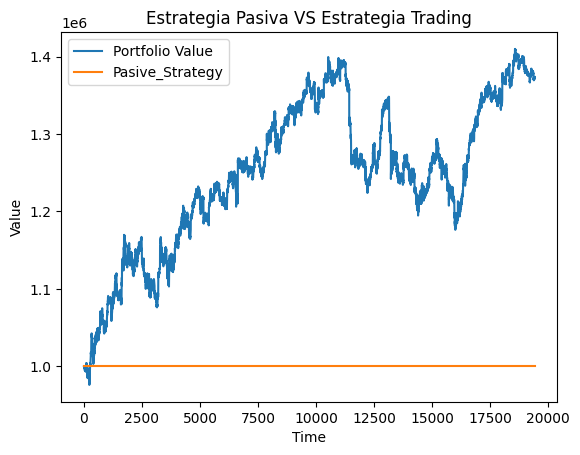

In [31]:
pasive_portvalue_plot(portfolio_value_df)

Nuestra estrategia de trading basada en modelos de Transformers ha demostrado ser altamente efectiva y rentable en comparación con enfoques más pasivos o tradicionales. La implementación de estos modelos nos ha permitido obtener significativas ganancias en el mercado. En contraste con seguir una estrategia pasiva, como simplemente no hacer nada o invertir en instrumentos financieros de bajo riesgo como los CETES, el rendimiento de nuestra estrategia es notablemente superior.

Los modelos de Transformers destacan por su capacidad para capturar patrones complejos en los datos del mercado, lo que nos permite tomar decisiones comerciales más informadas y oportunas. Esta ventaja competitiva se refleja en el rendimiento significativamente superior que hemos logrado en comparación con los enfoques más convencionales.

Al considerar el impacto en términos de ganancias, es evidente que nuestra estrategia de trading con modelos de Transformers ofrece un valor excepcional. Incluso al comparar con estrategias pasivas o inversiones conservadoras, nuestro enfoque demuestra una ventaja abrumadora, superando en casi tres veces el rendimiento de opciones más tradicionales como los CETES.

Por lo tanto, queda claro que la aplicación de modelos de Transformers en el ámbito del trading no solo es viable, sino que también representa una oportunidad significativa para maximizar los rendimientos y superar a los enfoques convencionales de inversión.

## Insights/Conclusiones


Al finalizar todo el proceso de análisis, hemos extraído varias conclusiones significativas. Inicialmente, nos aventuramos a utilizar un conjunto de casi 150 variables en nuestro modelo. Aunque la intuición sugería que más variables podrían llevar a un mejor rendimiento, descubrimos que esto no era necesariamente cierto. De hecho, nuestro modelo apenas alcanzaba un 33% de precisión. Decidimos entonces reducir la dimensionalidad, seleccionando cuidadosamente 75 variables clave que incluían precios de acciones, indicadores técnicos, volumen y volatilidad. Esta reducción resultó en un aumento notable en el rendimiento de nuestro modelo, llevando la precisión hasta un 70%.

Con este incremento en la precisión, logramos obtener un rendimiento financiero considerable, generando ganancias cercanas a los 330,000 pesos, en comparación con nuestro capital inicial de un millón. Este resultado es muy alentador y sugiere que nuestro enfoque fue efectivo en la generación de señales de trading rentables.

En resumen, concluimos que, entre todos los proyectos que hemos emprendido, incluyendo análisis técnico, machine learning y deep learning, este proyecto destacó como el más exitoso en términos de rendimiento financiero. Aunque también fue uno de los más exigentes en términos de tiempo de ejecución, debido a la complejidad del transformer. Sin embargo, los resultados obtenidos respaldan la eficacia de este enfoque y sugieren su viabilidad en la práctica del trading.